In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, plot_roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, plot_confusion_matrix
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import utils
import preprocessing

In [2]:
df, pa = preprocessing.preprocessing_significantes(utils.feature_engineering(utils.get_data()))

In [3]:
params = { 'C': np.linspace(0.1, 5, 10), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'] }
model = SVC(probability=True)

In [4]:
gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, verbose = 10)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, pa, random_state=112)

In [6]:
%%time
gscv.fit(X_train, y_train)
score = roc_auc_score(y_test, gscv.predict_proba(X_test)[:,1])

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 41.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 52.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 63.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 74.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 92.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 103.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 117.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 131.1min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:

CPU times: user 3min 6s, sys: 846 ms, total: 3min 7s
Wall time: 2h 55min 25s


In [7]:
gscv.best_params_

{'C': 2.277777777777778, 'kernel': 'rbf'}

In [8]:
score

0.8837322503756644

In [9]:
print(classification_report(y_test,gscv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6182
           1       0.69      0.58      0.63      1959

    accuracy                           0.84      8141
   macro avg       0.78      0.75      0.77      8141
weighted avg       0.83      0.84      0.83      8141



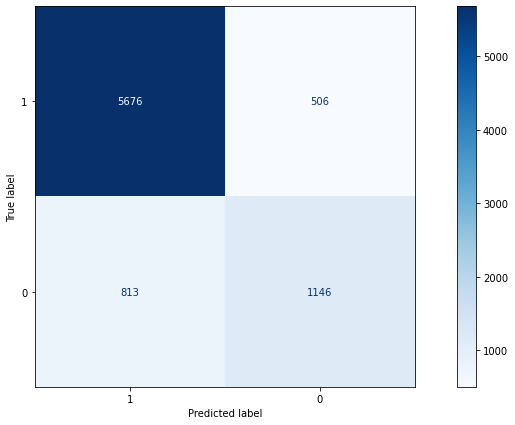

In [10]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

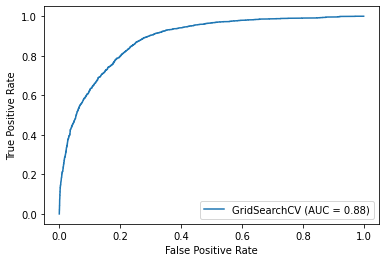

In [11]:
plot_roc_curve(gscv, X_test, y_test)